In [37]:
import os
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
import mistsim as ms
import scipy as sp

n_cpus = 4
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
NBINS = 1

### Load data

['ant_temp', 'freq', 'lst']


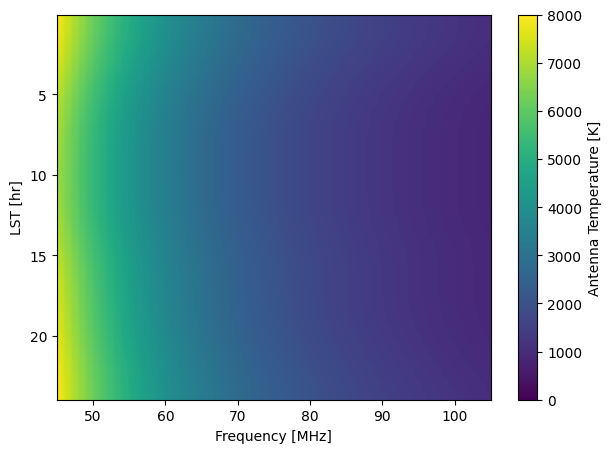

In [20]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
FLOW = 45
FHIGH = 105
indx = (freq >= FLOW) * (freq <= FHIGH)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

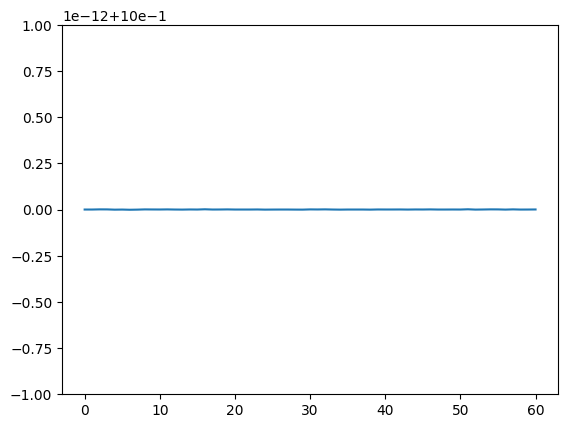

In [18]:
cut = nspec % NBINS
if cut == 0:
    fg_bin = temp.copy()
else:
    fg_bin = temp[:-cut]
fg_bin = fg_bin.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [19]:
tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = fg_mean[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(fg_bin, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

### Global signal

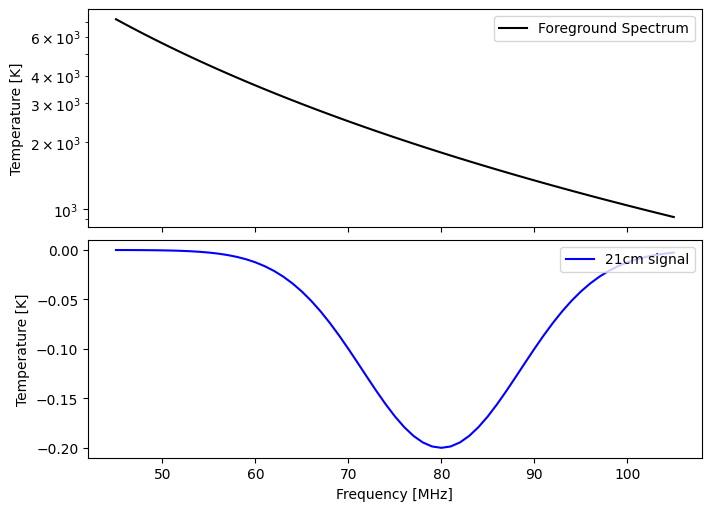

In [7]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

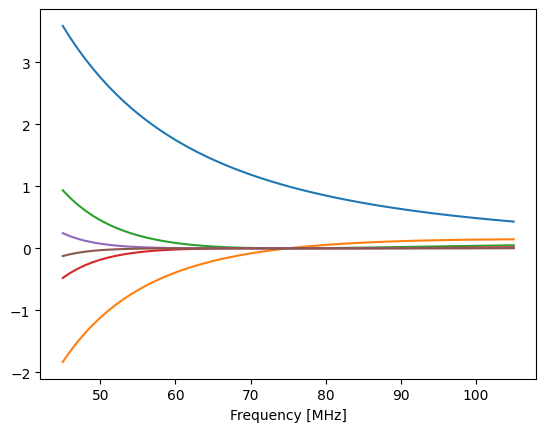

In [8]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

In [9]:
NFG = [6]
lst_bins = [ms.lstbin.LSTBin(freq, fg_bin[i]+noise[i], np.diag(sigma_inv[i]), TRUE_T21, NFG[i]) for i in range(NBINS)]

### Initialize and run sampler

In [10]:
nparticles = 64
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 15it [00:23,  2.17s/it, beta=0.00945, calls=11520, ESS=0.951, logZ=-5.21, accept=0.2, N=11, scale=0.219, corr=0.924]  Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "

KeyboardInterrupt: 

In [ ]:
_ = pc.plotting.run(results, width=7, height=7)

In [ ]:
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)

In [ ]:
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [ ]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

# Chromaticity correction

['ant_temp', 'freq', 'lst']


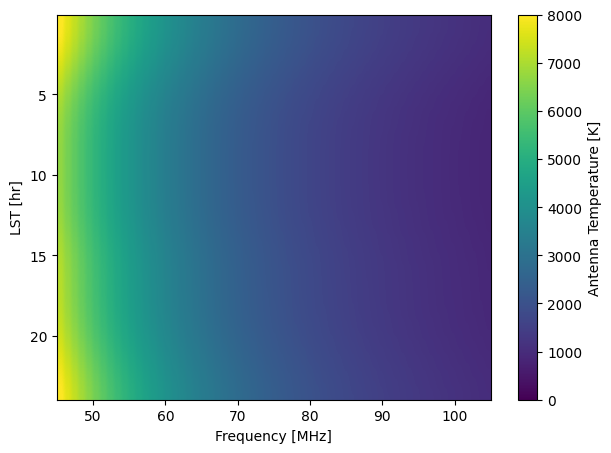

In [11]:
ac_temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5",
    print_key=True,
)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

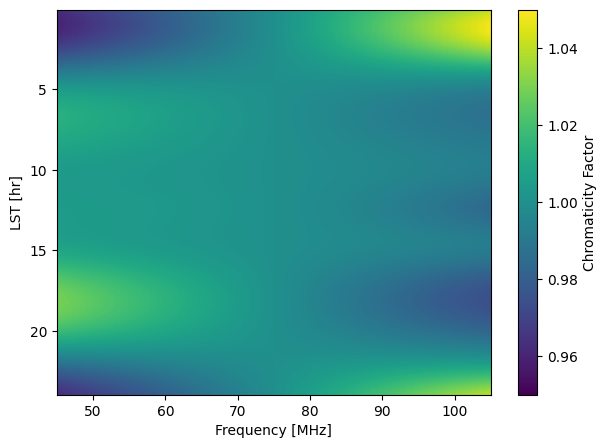

In [12]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [58]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    fg_bin = ctemp.copy()
else:
    fg_bin = ctemp[:-cut]
fg_bin = fg_bin.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(fg_bin+TRUE_T21/chrom, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

schris = noise_75 * fg_bin / t75 / np.sqrt(tint_ratio)

False
(1, 61)


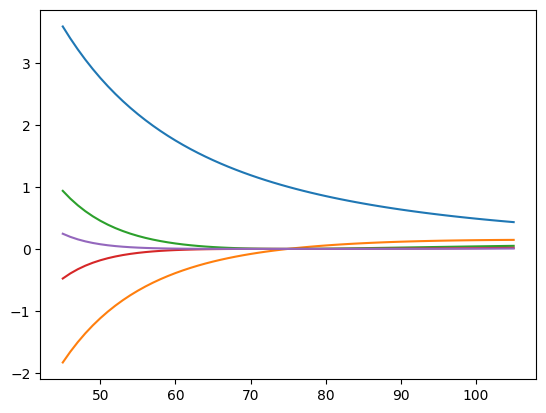

In [59]:
f0 = 75
def data():
    folder_file = "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5"
    BF_file_ch = "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5"
    BF_file_ach = "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5"
    lst, freq, t_conv = ms.utils.read_hdf5_convolution(folder_file)

    t21 = TRUE_PARAMS["a"] * np.exp(
        -((freq - TRUE_PARAMS["nu21"]) ** 2) / (2 * (TRUE_PARAMS["w"] / (2 * np.sqrt(2 * np.log(2)))) ** 2)
    )
    t_all = t_conv + t21
    
    lst, freq, BF_ch = ms.utils.read_hdf5_convolution(BF_file_ch)
    lst, freq, BF_ach = ms.utils.read_hdf5_convolution(BF_file_ach)
    BF = BF_ch / BF_ach
    avBF = np.mean(BF, axis=0)

    avt = np.mean(t_all / BF, axis=0)
    f = freq[(freq >= FLOW) & (freq <= FHIGH)]
    tx = avt[(freq >= FLOW) & (freq <= FHIGH)]
    s = (tx / tx[f == f0]) * 3e-3
    bb = avBF[(freq >= FLOW) & (freq <= FHIGH)]

    noise = np.random.normal(scale=s)
    t = tx + noise

    return f, t, s, bb, tx, avt

f, t, s, bb, tx, avt = data()
noise_raul = t - tx


SIGMA = np.diag(s**2)
inv_SIGMA = np.linalg.inv(SIGMA)


# "Design" matrix
nterms_fg = 5
AT = np.zeros((nterms_fg, len(f)))

for i in range(nterms_fg):
    AT[i, :] = ((f / f0) ** (-2.5)) * ((np.log(f / f0)) ** i)

A = AT.T

plt.figure()
for i in range(A.shape[1]):
    plt.plot(f, A[:, i])
plt.show()

C = np.linalg.inv(np.matmul(AT, np.matmul(inv_SIGMA, A)))
inv_SIGMA_fg = np.linalg.inv(np.matmul(A, np.matmul(C, AT)))
V = np.linalg.inv(inv_SIGMA_fg - inv_SIGMA)
inv_SIGMA_new = np.linalg.inv(SIGMA + V)


In [60]:
schris/s

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [61]:
avt.shape

(101,)

In [62]:
np.allclose(tx, fg_bin)

True

In [63]:
NFG = [5]
lst_bins = [ms.lstbin.LSTBin(freq, fg_bin[i]+noise[i], np.diag(sigma_inv[i]), TRUE_T21, NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [64]:
def fit_polynomial_fourier(model_type, xdata, ydata, nterms, Weights=1):
    AT = np.zeros((nterms, len(xdata)))
    if model_type == "LINLOG":
        for i in range(nterms):
            AT[i, :] = (xdata ** (-2.5)) * ((np.log(xdata)) ** i)

    # if no weights are given
    if np.isscalar(Weights):
        W = np.eye(len(xdata))

    # if a vector is given
    elif np.ndim(Weights) == 1:
        W = np.diag(Weights)

    # if a matrix is given
    elif np.ndim(Weights) == 2:
        W = Weights

    # sqrt of weight matrix
    sqrtW = np.sqrt(W)

    # transposing matrices so 'frequency' dimension is along columns
    A = AT.T
    ydata = np.reshape(ydata, (-1, 1))

    # A and ydata "tilde"
    WA = np.dot(sqrtW, A)
    Wydata = np.dot(sqrtW, ydata)

    # solving system using 'short' QR decomposition (see R. Butt, Num. Anal. Using MATLAB)
    Q1, R1 = sp.linalg.qr(WA, mode="economic")  # returns
    param = sp.linalg.solve(R1, np.dot(Q1.T, Wydata))

    model = np.dot(A, param)
    error = ydata - model
    DF = len(xdata) - len(param) - 1
    wMSE = (1 / DF) * np.dot(
        error.T, np.dot(W, error)
    )  # This is correct because we also have the Weight matrix in the (AT * W * A)^-1.
    wRMS = np.sqrt(np.dot(error.T, np.dot(W, error)) / np.sum(np.diag(W)))
    inv_pre_cov = np.linalg.inv(np.dot(R1.T, R1))
    cov = wMSE * inv_pre_cov

    # back to input format
    ydata = ydata.flatten()
    model = model.flatten()
    param = param.flatten()


    return param, model, wRMS, cov, wMSE

test_params = (-0.1, 15, 75)

def llraul(params):
    m = ms.utils.gauss(freq, *test_params)
    tc = t - m/bb
    p = fit_polynomial_fourier("LINLOG", freq/f0, tc, nterms_fg, Weights=1/s**2)
    d = tc - p[1]
    return -1/2 * np.matmul(d, np.matmul(inv_SIGMA_new, d))

llraul(test_params)

-2047.929485036214

In [65]:
from mistsim.sampler import log_likelihood

log_likelihood(test_params, lst_bins)

-9784.515566770533

In [29]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 


In [ ]:
results = sampler.run_sampler(lst_bins, add_samples=10000)

In [ ]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [ ]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)